# 1 Multi-class Classification

In [1]:
import numpy as np
import scipy.io as sio
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import math

## 1.1 Dataset

In [2]:
data = sio.loadmat('data/ex3data1.mat')
data

{'X': array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]),
 '__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct 16 13:09:09 2011',
 '__version__': '1.0',
 'y': array([[10],
        [10],
        [10],
        ..., 
        [ 9],
        [ 9],
        [ 9]], dtype=uint8)}

In [3]:
# X is 5,000 examples of 20x20 pixel images, each image is a handwritten number
# Each 20x20 image is stored as a 400-dimensional vector
data['X'].shape

(5000, 400)

In [4]:
# y is the numeral represented by each image
data['y'].shape

(5000, 1)

In [5]:
# Store in numpy arrays to make things easier
X = data['X']
y = data['y']

## 1.2 Visualizing the data

In [6]:
m = X.shape[0] # number of examples

In [7]:
# Randomly select 100 images to display
rand_indices = np.random.permutation(m)
sel = X[rand_indices[0:100], :]

In [8]:
def displayData(X):
    '''
    Displays 2D data stored in X in a nice grid.
    '''
    m = X.shape[0] # number of images
    display_rows = math.floor(math.sqrt(m))
    display_cols = math.ceil(m / display_rows)
    
    n = X.shape[1] # total number of pixels per image
    image_side = int(math.sqrt(n))
    
    plt.figure(figsize=(8,8))
    
    for i in range(m):
        image = X[i]
        image = np.reshape(image, (image_side, image_side), order='F')
        plt.subplot(display_rows, display_cols, i+1)
        plt.imshow(image, cmap='Greys')
        plt.axis('off')

    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

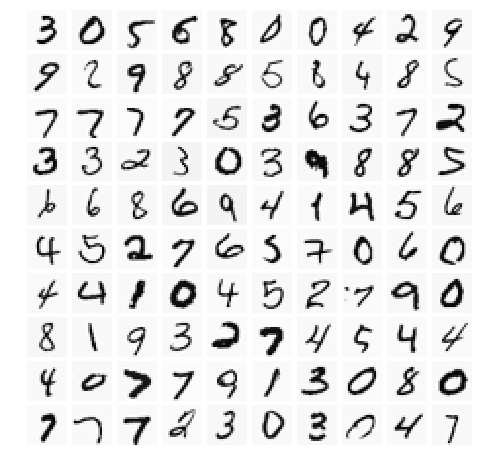

In [9]:
displayData(sel)

## 1.3 Vectorizing Logistic Regression

### 1.3.1 Vectorizing the cost function

In [10]:
# Test case for lrCostFunction
theta_t = np.array([-2, -1, 1, 2])
lambda_t = 3

X_0 = np.ones([5,1])
X_i = np.reshape(np.arange(0.1, 1.6, 0.1), [5,3], order='F')
X_t = np.column_stack((X_0, X_i))
X_t

array([[ 1. ,  0.1,  0.6,  1.1],
       [ 1. ,  0.2,  0.7,  1.2],
       [ 1. ,  0.3,  0.8,  1.3],
       [ 1. ,  0.4,  0.9,  1.4],
       [ 1. ,  0.5,  1. ,  1.5]])

In [11]:
y_t = np.array([1,0,1,0,1])
y_t

array([1, 0, 1, 0, 1])

In [12]:
def sigmoid(z):
    g = 1. / (1. + math.exp(-z))
    return g

sigmoid = np.vectorize(sigmoid)

In [13]:
def lrCostFunction(theta, X, y, Lambda):
    '''
    Computes cost and gradient for regularised logisitic regression, without any for loops!
    '''
    m = len(y) # number of examples
    
    
    # Cost
    J = 0
    J1 = 0
    J2 = 0
    
    z = np.dot(X, theta)
    J1 = (1/m) * np.sum(-y*np.log(sigmoid(z)) - (1 - y)*np.log((1 - sigmoid(z))))
    J2 = np.sum(theta[1:]**2) * Lambda / (2*m)
    J = J1 + J2
    
    
    # Gradient
    grad = np.zeros(theta.shape)
    
    z = np.dot(X, theta)    
    grad = (1/m) * np.dot(X.T, (sigmoid(z) - y))
    grad[1:] += Lambda/m * theta[1:] 
    
    
    return J, grad

In [14]:
J, grad = lrCostFunction(theta_t, X_t, y_t, lambda_t)

In [15]:
print('\nCost:\n %.6f' %(J))
print('Expected cost:\n 2.534819\n')
print('Gradients:\n', grad)
print('Expected gradients:')
print(' 0.146561\t -0.548558\t 0.724722\t 1.398003\n')


Cost:
 2.534819
Expected cost:
 2.534819

Gradients:
 [ 0.14656137 -0.54855841  0.72472227  1.39800296]
Expected gradients:
 0.146561	 -0.548558	 0.724722	 1.398003



## 1.4 One-vs-all Classification

In [16]:
def oneVsAll(X, y, num_labels, Lambda):
    '''
    Trains num_labels logistic regression classifiers and returns all
    the classifiers in a matrix all_theta, where the i-th row of all_theta 
    corresponds to the classifier for label i.
    '''
    m = X.shape[0] # number of examples
    n = X.shape[1] # number of pixels per example

    all_theta = np.zeros([num_labels, n+1])

    # Add column of ones to X for bias
    X = np.column_stack((np.ones(m), X))
    
    for c in range(num_labels):

        # Set Initial theta
        initial_theta = np.zeros([n+1, 1])
        y_bools = (y==c).astype(int).reshape([m,])

        res = minimize(fun=lrCostFunction, x0=initial_theta, args=(X, y_bools, Lambda), method='CG',
                       jac=True, options={'maxiter':50})
        
        theta = res.x
        all_theta[c] = theta

    return all_theta

In [17]:
Lambda = 0.1
num_labels = 10 # 10 labels, from 0 to 9. Note that "0" is mapped to label 10.

all_theta = oneVsAll(X, y, num_labels, Lambda)